In [1]:
! pip install yfinance

In [17]:
! pip install pandas ta scikit-learn

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29411 sha256=3ebfbabf8663ae7a0fb6da6decc9441854ff5522ede4be65ad5fdc1c92628121
  Stored in directory: /Users/utsavdhanuka/Library/Caches/pip/wheels/61/d8/66/8018676d483fa5edb5337a7a25ee8c029ac255be25f90f3cd5
Successfully built ta


In [2]:
import yfinance as yf
import pandas as pd
from datetime import datetime
from dateutil.relativedelta import relativedelta

In [22]:
# all indian IT sector stock tickers like TCS, Infosys, Wipro, etc.
ticker_list = ['TCS.NS', 'INFY.NS', 'WIPRO.NS', 'HCLTECH.NS', 'TECHM.NS', 'PERSISTENT.NS']

# function which accepts a ticker  and returns the data 
ticker = "TCS.NS"

# Set the date range: last 10 years from today (June 16, 2025)
def get_ticker_data(ticker):
            end_date = datetime(2025, 6, 16)
            start_date = end_date - relativedelta(years=10)

            try:
                # Fetch data from Yahoo Finance
                stock_data = yf.download(ticker, start=start_date, end=end_date, interval="1d")
                
                # Check if data is empty
                if stock_data.empty:
                    print("No data retrieved. Please check the ticker symbol or internet connection.")
                else:
                    # Reset index to make 'Date' a column
                    stock_data.reset_index(inplace=True)
                    
                    # Preview the first few rows
                    # print("\nFirst 5 rows of TCS data:")
                    print(stock_data.head())
                    
                    # Save data to a CSV file
                    output_file = f"{ticker}_10years_data.csv"
                    stock_data.to_csv(output_file, index=False)
                    print(f"\nData saved to {output_file}")
                    
                    # # Basic data summary
                    # print("\nData Summary:")
                    # print(f"Total rows: {len(stock_data)}")
                    # print(f"Columns: {list(stock_data.columns)}")
                    # print(f"Date range: {stock_data['Date'].min()} to {stock_data['Date'].max()}")

                    return stock_data

            except Exception as e:
                print(f"An error occurred: {str(e)}")



In [23]:
from ta.trend import SMAIndicator, EMAIndicator, MACD, PSARIndicator, CCIIndicator
from ta.momentum import RSIIndicator, StochasticOscillator, WilliamsRIndicator, ROCIndicator
from ta.volatility import BollingerBands, AverageTrueRange, KeltnerChannel
from ta.volume import OnBalanceVolumeIndicator, AccDistIndexIndicator, ChaikinMoneyFlowIndicator, VolumeWeightedAveragePrice
from sklearn.preprocessing import MinMaxScaler

def calculate_technical_indicators(df, output_file):
    if df is None or df.empty:
         print("No data retrieved. Check ticker or connection.")
    else:
        print("Processing data...")

        # Reset index to make 'Date' a column
        df.reset_index(inplace=True)

        # Flatten MultiIndex columns if they exist
        df.columns = [col[0] if isinstance(col, tuple) else col for col in df.columns]

        # Ensure Date column is datetime type
        df['Date'] = pd.to_datetime(df['Date'])

        # Set index temporarily for VWAP
        df.set_index('Date', inplace=True)

        # Calculate technical indicators
        print("Calculating indicators...")

        # Trend indicators
        df['SMA_20'] = SMAIndicator(close=df['Close'], window=20).sma_indicator()
        df['EMA_20'] = EMAIndicator(close=df['Close'], window=20).ema_indicator()
        macd = MACD(close=df['Close'], window_slow=26, window_fast=12, window_sign=9)
        df['MACD'] = macd.macd()
        df['MACD_Signal'] = macd.macd_signal()
        df['PSAR'] = PSARIndicator(high=df['High'], low=df['Low'], close=df['Close']).psar()
        df['CCI_20'] = CCIIndicator(high=df['High'], low=df['Low'], close=df['Close'], window=20).cci()

        # Momentum indicators
        df['RSI_14'] = RSIIndicator(close=df['Close'], window=14).rsi()
        stoch = StochasticOscillator(high=df['High'], low=df['Low'], close=df['Close'], window=14, smooth_window=3)
        df['Stoch_K'] = stoch.stoch()
        df['Stoch_D'] = stoch.stoch_signal()
        df['WilliamsR_14'] = WilliamsRIndicator(high=df['High'], low=df['Low'], close=df['Close'], lbp=14).williams_r()
        df['ROC_12'] = ROCIndicator(close=df['Close'], window=12).roc()

        # Volatility indicators
        bb = BollingerBands(close=df['Close'], window=20, window_dev=2)
        df['BB_Upper'] = bb.bollinger_hband()
        df['BB_Middle'] = bb.bollinger_mavg()
        df['BB_Lower'] = bb.bollinger_lband()
        df['ATR_14'] = AverageTrueRange(high=df['High'], low=df['Low'], close=df['Close'], window=14).average_true_range()
        kc = KeltnerChannel(high=df['High'], low=df['Low'], close=df['Close'], window=20)
        df['KC_Upper'] = kc.keltner_channel_hband()
        df['KC_Lower'] = kc.keltner_channel_lband()

        # Volume indicators
        df['OBV'] = OnBalanceVolumeIndicator(close=df['Close'], volume=df['Volume']).on_balance_volume()
        df['AD_Line'] = AccDistIndexIndicator(high=df['High'], low=df['Low'], close=df['Close'], volume=df['Volume']).acc_dist_index()
        df['CMF_20'] = ChaikinMoneyFlowIndicator(high=df['High'], low=df['Low'], close=df['Close'], volume=df['Volume'], window=20).chaikin_money_flow()
        df['VWAP'] = VolumeWeightedAveragePrice(high=df['High'], low=df['Low'], close=df['Close'], volume=df['Volume']).volume_weighted_average_price()

        # Reset index back
        df.reset_index(inplace=True)

        # Drop initial rows with NaNs due to rolling indicators
        df.dropna(inplace=True)

        # Normalize all numeric columns (excluding 'Date')
        print("Normalizing data...")
        scaler = MinMaxScaler()
        numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
        df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

        # Preview
        print("\nFirst 5 rows of normalized TCS data with indicators:")
        print(df.head())

        # Save to CSV
        # output_file = "TCS_10years_normalized_indicators.csv"
        df.to_csv(output_file, index=False)
        print(f"\n✅ Data saved to {output_file}")

        # # Summary
        # print("\n📊 Data Summary:")
        # print(f"Total rows: {len(df)}")
        # print(f"Columns: {list(df.columns)}")
        # print(f"Date range: {df['Date'].min().date()} to {df['Date'].max().date()}")
# function which accepts a ticker and returns the data in a dataframe
    

[*********************100%***********************]  1 of 1 completed
/Users/utsavdhanuka/miniconda3/envs/env_pytorch/lib/python3.9/site-packages/ta/trend.py:1030: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self._psar[i] = high2



First 5 rows of TCS data:
Price        Date        Close         High          Low         Open   Volume
Ticker                  TCS.NS       TCS.NS       TCS.NS       TCS.NS   TCS.NS
0      2015-06-16  1060.639526  1063.721819  1053.229385  1055.572777  1267396
1      2015-06-17  1061.398926  1067.880077  1056.332179  1064.438953  1975720
2      2015-06-18  1068.260742  1075.121965  1058.950570  1061.906174  2165046
3      2015-06-19  1076.494141  1078.795268  1067.015119  1070.350687  1999610
4      2015-06-22  1094.207031  1097.795980  1075.417831  1075.417831  1102002

Data saved to TCS.NS_10years_data.csv

Data Summary:
Total rows: 2468
Columns: [('Date', ''), ('Close', 'TCS.NS'), ('High', 'TCS.NS'), ('Low', 'TCS.NS'), ('Open', 'TCS.NS'), ('Volume', 'TCS.NS')]
Date range: 2015-06-16 00:00:00 to 2025-06-13 00:00:00
Processing data...
Calculating indicators...
Normalizing data...

First 5 rows of normalized TCS data with indicators:
         Date     index     Close      High      

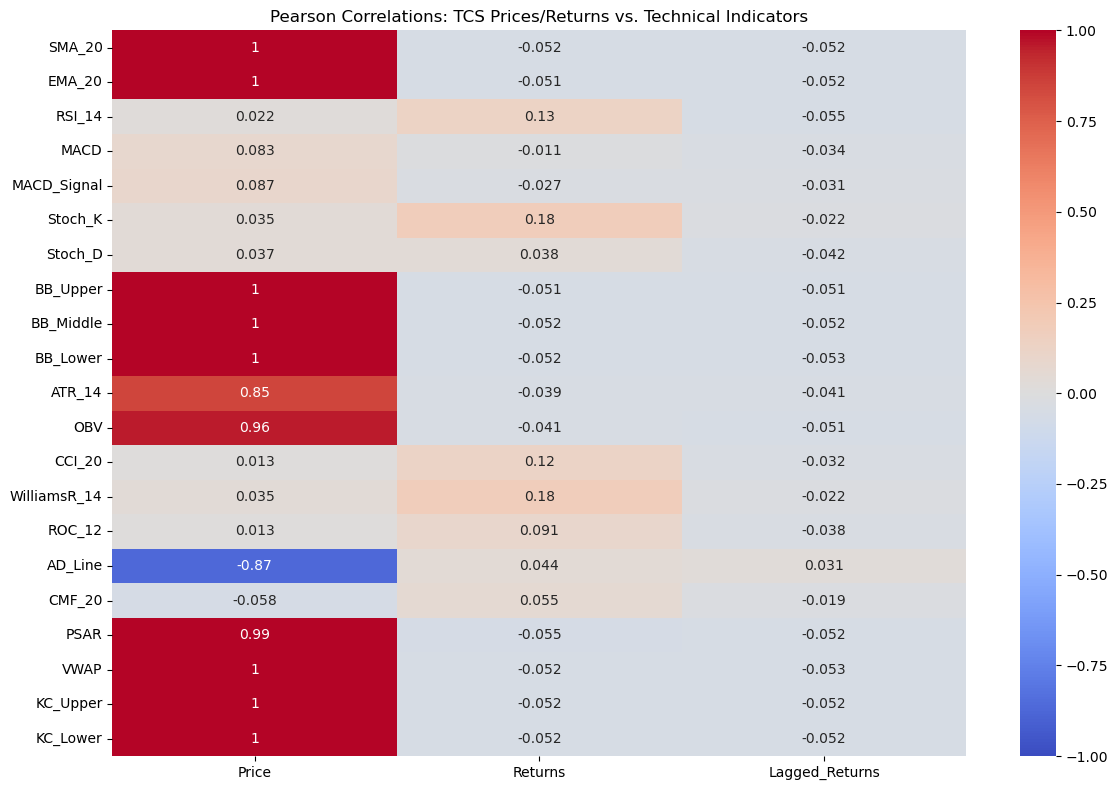

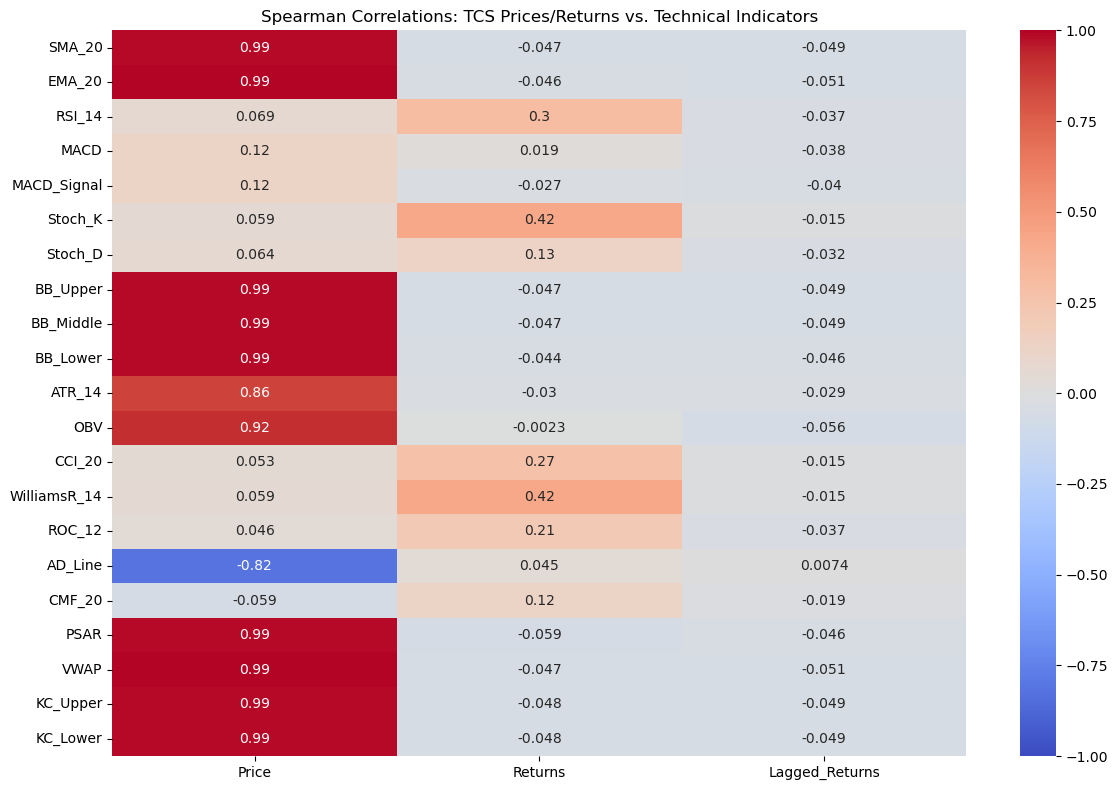


Significant Pearson Correlations (|corr| > 0.3) for Returns or Lagged Returns:
Empty DataFrame
Columns: [Price, Returns, Lagged_Returns]
Index: []

Significant Spearman Correlations (|corr| > 0.3) for Returns or Lagged Returns:
                 Price   Returns  Lagged_Returns
RSI_14        0.068932  0.300127       -0.036595
Stoch_K       0.058823  0.424066       -0.014511
WilliamsR_14  0.058823  0.424066       -0.014511


In [24]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr, spearmanr
import seaborn as sns
import matplotlib.pyplot as plt
def calculate_correlations(data, x_col, y_col, lag=0):
    if lag > 0:
        x = data[x_col].shift(lag)
    else:
        x = data[x_col]
    y = data[y_col]

    # Drop NaNs and Infs
    valid_data = pd.concat([x, y], axis=1).replace([np.inf, -np.inf], np.nan).dropna()
    
    if len(valid_data) < 3:  # Ensure enough samples
        return np.nan, np.nan

    try:
        # Pearson correlation
        pearson_corr, _ = pearsonr(valid_data.iloc[:, 0], valid_data.iloc[:, 1])
        # Spearman correlation
        spearman_corr, _ = spearmanr(valid_data.iloc[:, 0], valid_data.iloc[:, 1])
        return pearson_corr, spearman_corr
    except:
        return np.nan, np.nan
    
def plot_correlation_values(csv_file,ticker):

    try:
            df = pd.read_csv(csv_file)
    except FileNotFoundError:
        print(f"Error: {csv_file} not found. Please run the previous code to generate it.")
        exit()

    df['Returns'] = df['Close'].pct_change()

# Drop rows with NaN values (due to returns or indicator lookback periods)
    df = df.dropna()

    # Define columns for correlation analysis
    price_col = 'Close'  # For price-based correlations
    returns_col = 'Returns'  # For return-based correlations
    indicator_cols = ['SMA_20', 'EMA_20', 'RSI_14', 'MACD', 'MACD_Signal', 'Stoch_K', 'Stoch_D',
                    'BB_Upper', 'BB_Middle', 'BB_Lower', 'ATR_14', 'OBV', 'CCI_20', 'WilliamsR_14',
                    'ROC_12', 'AD_Line', 'CMF_20', 'PSAR', 'VWAP', 'KC_Upper', 'KC_Lower']

    # Initialize dictionaries to store correlations
    pearson_results = {'Price': {}, 'Returns': {}, 'Lagged_Returns': {}}
    spearman_results = {'Price': {}, 'Returns': {}, 'Lagged_Returns': {}}

    # Calculate correlations for each indicator
    for col in indicator_cols:
        # 1. Price vs. Indicator (non-lagged)
        pearson_corr, spearman_corr = calculate_correlations(df, col, price_col)
        pearson_results['Price'][col] = pearson_corr
        spearman_results['Price'][col] = spearman_corr
        
        # 2. Returns vs. Indicator (non-lagged)
        pearson_corr, spearman_corr = calculate_correlations(df, col, returns_col)
        pearson_results['Returns'][col] = pearson_corr
        spearman_results['Returns'][col] = spearman_corr
        
        # 3. Returns vs. Lagged Indicator (t-1)
        pearson_corr, spearman_corr = calculate_correlations(df, col, returns_col, lag=1)
        pearson_results['Lagged_Returns'][col] = pearson_corr
        spearman_results['Lagged_Returns'][col] = spearman_corr

    # Convert results to DataFrames
    pearson_df = pd.DataFrame(pearson_results)
    spearman_df = pd.DataFrame(spearman_results)

    # Print correlation results
    print("\nPearson Correlation Coefficients:")
    print(pearson_df)
    print("\nSpearman Correlation Coefficients:")
    print(spearman_df)

    # Save correlation results to CSV
    pearson_df.to_csv(f"{ticker}_pearson_correlations.csv")
    spearman_df.to_csv(f"{ticker}_spearman_correlations.csv")
    print("\nCorrelation results saved to TCS_pearson_correlations.csv and TCS_spearman_correlations.csv")

    # Visualize correlations with heatmaps
    plt.figure(figsize=(12, 8))
    sns.heatmap(pearson_df, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
    plt.title("Pearson Correlations: TCS Prices/Returns vs. Technical Indicators")
    plt.tight_layout()
    plt.savefig(f"{ticker}_pearson_heatmap.png")
    plt.show()

    plt.figure(figsize=(12, 8))
    sns.heatmap(spearman_df, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
    plt.title("Spearman Correlations: TCS Prices/Returns vs. Technical Indicators")
    plt.tight_layout()
    plt.savefig(f"{ticker}_spearman_heatmap.png")
    plt.show()

    # Highlight significant correlations (absolute value > 0.3 for Returns or Lagged_Returns)
    print("\nSignificant Pearson Correlations (|corr| > 0.3) for Returns or Lagged Returns:")
    significant_pearson = pearson_df[(pearson_df['Returns'].abs() > 0.3) | (pearson_df['Lagged_Returns'].abs() > 0.3)]
    print(significant_pearson)

    print("\nSignificant Spearman Correlations (|corr| > 0.3) for Returns or Lagged Returns:")
    significant_spearman = spearman_df[(spearman_df['Returns'].abs() > 0.3) | (spearman_df['Lagged_Returns'].abs() > 0.3)]
    print(significant_spearman)
        
    


# run the function calculate_technical_indicators
ticker_symbol = 'TCS.NS'
stock_data = get_ticker_data(ticker_symbol)
output_file = f"{ticker_symbol}_10years_normalized_indicators.csv"
calculate_technical_indicators(stock_data,output_file)

plot_correlation_values(output_file,ticker_symbol)
